In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchsummary import torchsummary
import matplotlib.pyplot as plt

In [18]:
# Define the Residual Block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels)
        self.conv4 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn4 = nn.BatchNorm2d(out_channels)
        self.conv5 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn5 = nn.BatchNorm2d(out_channels)
        self.stride = stride

        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.shortcut = nn.Identity()

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv3(out)
        out = self.bn3(out)
        out = self.relu(out)
        out = self.conv4(out)
        out = self.bn4(out)
        out = self.relu(out)
        out = self.conv5(out)
        out = self.bn5(out)
        out += self.shortcut(residual)
        out = self.relu(out)
        return out

In [19]:
class ResidualCNN(nn.Module):
    def __init__(self, num_classes):
        super(ResidualCNN, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self.make_layer(64, 3)
        self.layer2 = self.make_layer(128, 4, stride=2)
        self.layer3 = self.make_layer(256, 6, stride=2)
        self.layer4 = self.make_layer(512, 3, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def make_layer(self, out_channels, num_blocks, stride=1):
        layers = []
        layers.append(ResidualBlock(self.in_channels, out_channels, stride))
        self.in_channels = out_channels
        for _ in range(1, num_blocks):
            layers.append(ResidualBlock(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.maxpool(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [20]:
# Data preprocessing and augmentation
data_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
])

# Load the dataset
dataset = ImageFolder(root="D:/Development/DeepLearning/data/lung_colon_image_set", transform=data_transforms)
class_names = dataset.classes

In [21]:
# Split the dataset into train and test sets
train_size = len(dataset) // 2
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [22]:
# Create the model and optimizer
model = ResidualCNN(num_classes=5)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

summary = torchsummary.summary(model, input_size=(3, 224, 224), device=device.type)
print(summary)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11           [-1, 64, 56, 56]          36,864
      BatchNorm2d-12           [-1, 64, 56, 56]             128
             ReLU-13           [-1, 64, 56, 56]               0
           Conv2d-14           [-1, 64,

In [23]:
num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss/len(train_loader):.4f}, Train Accuracy: {(100*correct/total):.2f}%")

Epoch [1/5], Train Loss: 0.1148, Train Accuracy: 96.92%
Epoch [2/5], Train Loss: 0.0232, Train Accuracy: 99.32%
Epoch [3/5], Train Loss: 0.0159, Train Accuracy: 99.53%
Epoch [4/5], Train Loss: 0.0168, Train Accuracy: 99.57%
Epoch [5/5], Train Loss: 0.0152, Train Accuracy: 99.55%


In [24]:
# Evaluate the model
model.eval()
test_loss = 0.0
correct = 0
total = 0
class_correct = [0] * len(class_names)
class_total = [0] * len(class_names)

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        c = (predicted == labels).squeeze()
        for i in range(labels.size(0)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

# Display accuracy with a pie chart
accuracy = 100 * correct / total
class_accuracy = [100 * class_correct[i] / class_total[i] for i in range(len(class_names))]

# Print test results
print(f"Test Loss: {test_loss/len(test_loader):.4f}")
print(f"Test Accuracy: {accuracy:.2f}%")
for i, class_name in enumerate(class_names):
    print(f"Accuracy of {class_name}: {class_accuracy[i]:.2f}%")

Test Loss: 0.0085
Test Accuracy: 99.88%
Accuracy of colon_image_sets: 99.70%
Accuracy of lung_image_sets: 100.00%


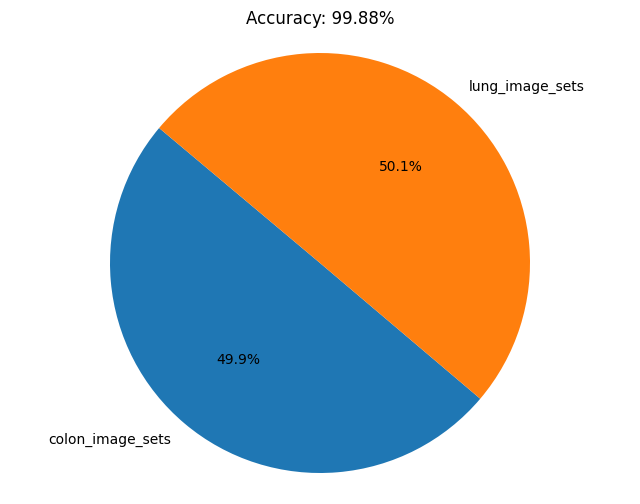

In [25]:
plt.figure(figsize=(8, 6))
plt.pie(class_accuracy, labels=class_names, autopct='%1.1f%%', startangle=140)
plt.title(f"Accuracy: {accuracy:.2f}%")
plt.axis('equal')
plt.show()